In [1]:
from xgboost import XGBRegressor
import sys, os
import pandas as pd

from sklearn.metrics import root_mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import joblib

sys.path.append(os.path.abspath("../features"))
from data_loading import create_features_and_targets
sys.path.append(os.path.abspath("../utils"))
from feature_rankers import feature_ranking_PER, feature_ranking_SHAP, plot_PER_and_SHAP
from utils import (
    log_mlflow_metrics_and_model,
    evaluate_predictions_3_days,
    plot_predictions_vs_true,
)

/Users/akseljoonas/.virtualenvs/pollution-forecasting/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
particle = "O3"
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data/processed/_combined_data.csv")
data = pd.read_csv(data_path)
X_train, y_train, X_test, y_test, X_val, y_val = create_features_and_targets(data, particle)

Number of rows with missing values dropped: 1011


## Inspecting and saving the best model

In [3]:
# NO2 best model
best_model_NO2 = XGBRegressor(
    n_estimators=400, 
    learning_rate=0.01, 
    max_depth=3, 
    min_child_weight=2, 
    subsample=0.6727322424376836, 
    colsample_bytree=0.8045820840883416, 
    gamma=0.31027259407357566)

# O3 best model
best_model_O3 = XGBRegressor(
    learning_rate=0.07,  
    n_estimators=300,
    max_depth=9,
    min_child_weight=4,
    subsample=0.7869189270981738,
    colsample_bytree=0.5159227775632531,
    gamma=0.1067544017282278
)

if particle == "NO2":
    best_model = best_model_NO2
elif particle == "O3":
    best_model = best_model_O3
    
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
loaded_scaler = joblib.load(f'target_scaler_{particle}.joblib')
y_pred = loaded_scaler.inverse_transform(y_pred)
y_test = loaded_scaler.inverse_transform(y_test)

print(f"Model for {particle} has been trained successfully")

Model for O3 has been trained successfully


In [4]:
rmse = root_mean_squared_error(y_test, y_pred)
smape = mean_absolute_percentage_error(y_pred, y_test, symmetric=True)
print(f"RMSE: {rmse}, SMAPE: {smape}")

RMSE: 15.860674112513871, SMAPE: 0.34557215833015126


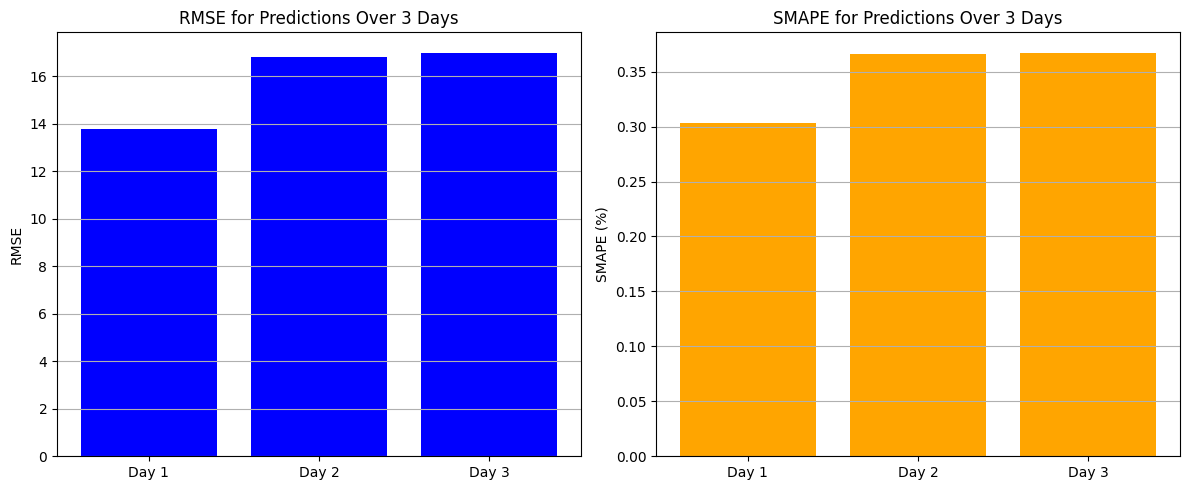

In [5]:
rmse_list, smape_list, bar_plot = evaluate_predictions_3_days(y_pred, y_test)

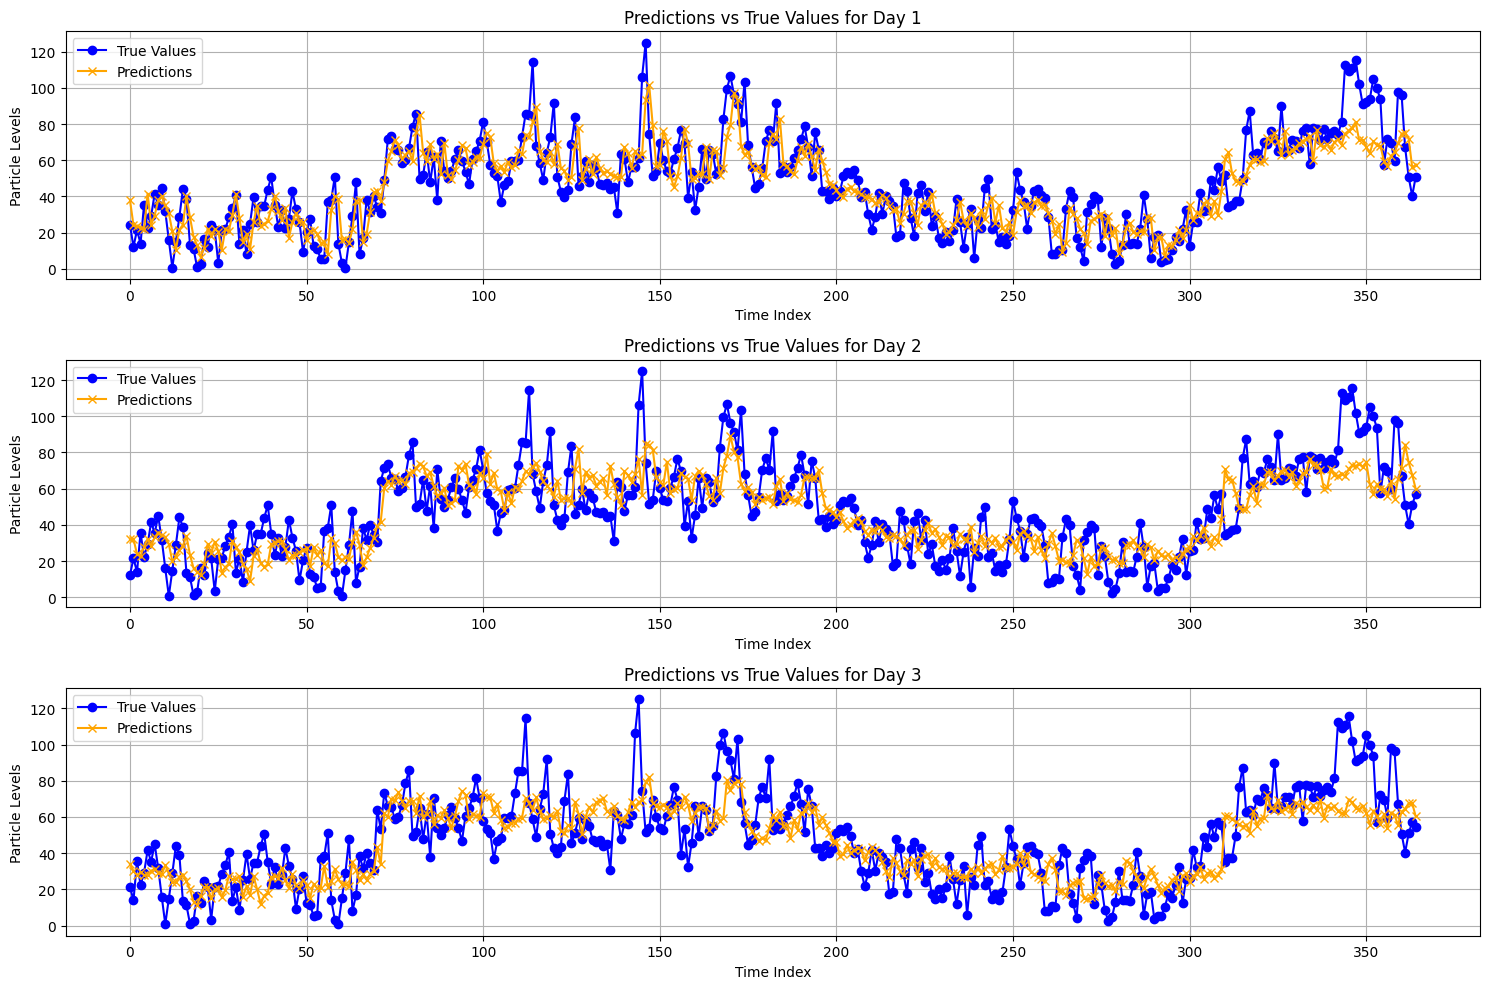

In [6]:
line_plot = plot_predictions_vs_true(y_pred, y_test)

In [7]:
feature_rank_PER = feature_ranking_PER(best_model, X_train, y_train)
feature_rank_SHAP = feature_ranking_SHAP("XGBoost", best_model, X_train)

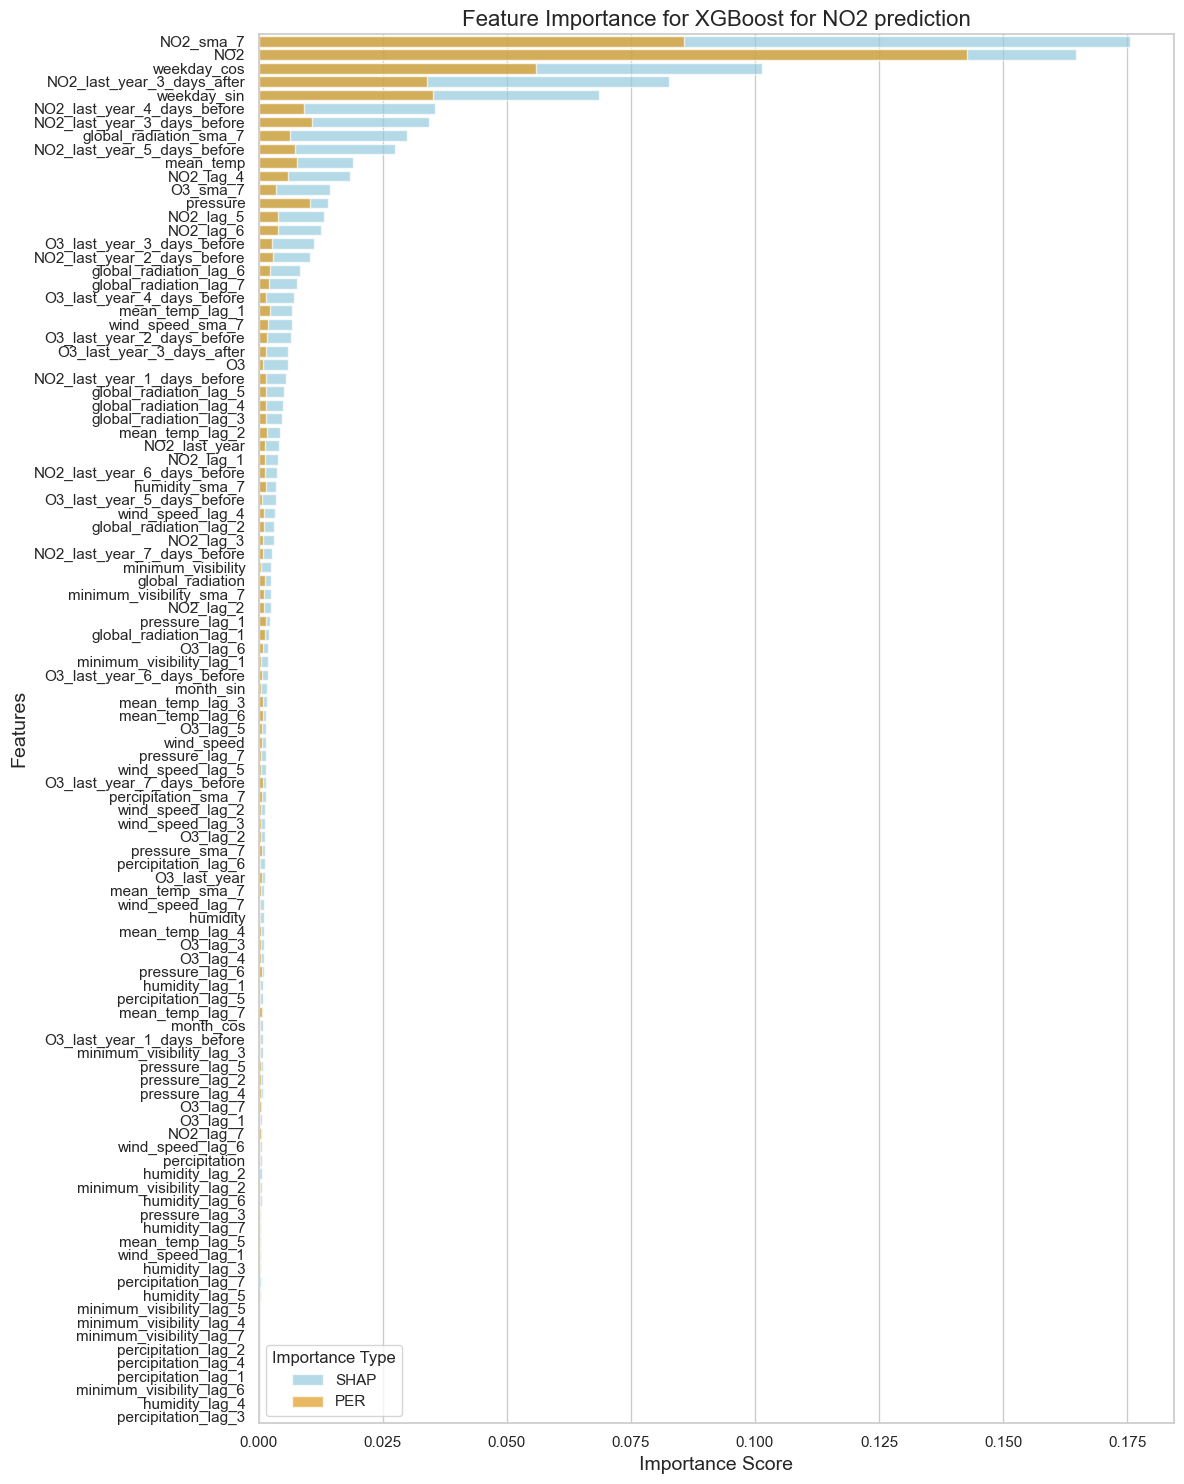

<Figure size 640x480 with 0 Axes>

In [11]:
rankings_plot = plot_PER_and_SHAP(feature_rank_PER, feature_rank_SHAP, model_name=f"XGBoost for {particle} prediction")

In [16]:
log_mlflow_metrics_and_model(
    rmse, smape, best_model, X_train, line_plot, bar_plot, f"XGBoost_{particle}", params=None,
    losses_plot=None, feature_rankings_plot=rankings_plot
)

Registered model 'XGBoost_NO2' already exists. Creating a new version of this model...
2024/10/11 15:13:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_NO2, version 2
Created version '2' of model 'XGBoost_NO2'.
2024/10/11 15:13:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-bird-124 at: http://localhost:5555/#/experiments/0/runs/99db3f49541d431788afc2635971bfad.
2024/10/11 15:13:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5555/#/experiments/0.


Run ended.
